# Notebook de Modélisation

Librairies et paramétrages utilisés au long du notebook

In [1]:
import warnings
import pickle
import dill
from collections import defaultdict

import pandas as pd
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

Chargement des données et affichage des premières lignes

In [3]:
data = pd.read_csv('data/final_data.csv', index_col=[0])
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CARRIER,ORIGIN,DEST,DISTANCE,DEP_TIME,ARR_TIME,ELAPSED_TIME,DELAY,TO_HOLIDAYS
0,1,6,3,AA,DFW,DTW,986.0,11,14,158.0,-6.0,5
1,1,7,4,AA,DFW,DTW,986.0,11,14,158.0,-12.0,6
2,1,8,5,AA,DFW,DTW,986.0,11,14,158.0,7.0,7
3,1,9,6,AA,DFW,DTW,986.0,11,14,158.0,-5.0,8
5,1,11,1,AA,DFW,DTW,986.0,11,14,158.0,-3.0,7


## Préparation des données

Ici, notre but est de mettre les données dans le format adapté afin qu'elles puissent servir d'entrée à nos modèles plus tard.

Premièrement, binarisons chacune de nos variables catégorielles

In [4]:
nominal_encoder = defaultdict(LabelEncoder)
nominal_cols = ['CARRIER', 'ORIGIN', 'DEST']
data[nominal_cols] = (data[nominal_cols]
                      .apply(lambda x: nominal_encoder[x.name].fit_transform(x)))

data[nominal_cols].tail()

,CARRIER,ORIGIN,DEST
5635973,11,296,167
5635974,11,296,167
5635975,11,296,186
5635976,11,296,259
5635977,11,296,259


In [5]:
categorical_cols = ['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'DEP_TIME', 'ARR_TIME'] + nominal_cols
categorical_encoder = OneHotEncoder()
categoricals = categorical_encoder.fit_transform(data[categorical_cols])
categoricals.shape

(5074732, 731)

Étant donné les très grandes dimensions de notre jeu de données résultant, celui-ci a été converti dans un format de matrice creuse pour occuper le moins d'espace mémoire possible

Mettons nos attributs numériques au même format de données.

In [6]:
numeric_cols = ['DISTANCE', 'ELAPSED_TIME', 'TO_HOLIDAYS']

numericals = sparse.csr_matrix(data[numeric_cols])
numericals.shape

(5074732, 3)

Maintenant, joignons nos deux matrices pour obtenir une matrice de variables explicatives entière. Récupérons notre variable cible dans un objet vecteur à part.

In [7]:
X = sparse.hstack([numericals, categoricals], format='csr')
y = data['DELAY'].values

X.shape

(5074732, 734)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

Nous créons notre classe de normalisation personnalisée afin:
- de ne cibler que les variables numériques (dans les 3 premières colonnes)
- d'adapter la classe initiale de sklearn au format de matrice creuse

In [9]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        x_numericals = X[:, 0:3].toarray()
        self.scaler.fit(x_numericals)
        return self
    def transform(self, X):
        x_numericals = X[:, 0:3].toarray()
        # x_scaled = sparse.csr_matrix(self.scaler.transform(x_numericals))
        x_scaled = self.scaler.transform(x_numericals)
        X[:, 0:3] = x_scaled
        return X

## Modèle de base

Dans un premier temps, afin de pouvoir plus tard juger de l'utilité de nos modèles, de leur rapport performance/complexité, évaluons un modèle simple: celui-ci se contentra de prédire pour chaque observation la moyenne de la variable cible.

Calculons cette moyenne sur les données d'entrainement

In [10]:
baseline = Pipeline([
    ('scaler', Scaler()),
    ('regression', DummyRegressor(strategy='mean'))
])

baseline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', Scaler()), ('regression', DummyRegressor(constant=None, quantile=None, strategy='mean'))])

Évaluons l'erreur moyenne sur les données de validation

In [11]:
y_predict = baseline.predict(X_test)
MAE = mean_absolute_error(y_test, y_predict)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))

print('MAE: ', MAE)
print('RMSE: ', RMSE)

MAE:  11.075987137384892
RMSE:  14.388644481434344


## Régression linéaire

Utilisons les méthodes de cross-validation et de grid-search pour chercher la combinaison d'hyperparamètres pour avoir le meilleur modèle de régression pénalité. Le MAE est notre métrique de choix. Les différents hyperparamètres sur lesquels nous "jouons" influent:
- sur le poids de la pénalité dans la fonction de coût prise en compte lors du processus d'optimisation des modèles (alpha)
- sur le type de pénalité que l'on souhaite: entre régression `ridge` et régression `lasso`, ou une combinaison des deux

In [12]:
hyperparameters = {'regression__alpha': [1e-5],
                                         #,3e-5, 1e-4, 3e-4, 1e-3, 3e-3],
                   'regression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]}

regressor = Pipeline([
    ('scaler', Scaler()),
    ('regression', SGDRegressor(penalty='elasticnet', tol=1e-3, eta0=1e-3, 
                                max_iter=1000, random_state=0))
])

lr_gridsearch = GridSearchCV(regressor, hyperparameters, cv=10,
                             scoring='neg_mean_absolute_error',
                             n_jobs=-1, verbose=2)

lr_gridsearch.fit(X, y)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] .. regression__alpha=1e-05, regression__l1_ratio=0, total= 4.2min
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] .. regression__alpha=1e-05, regression__l1_ratio=0, total= 4.4min
[CV] regression__alpha=1e-05, regression__l1_ratio=0 .................
[CV] .. regression__alpha=1e-05, regression__l1_ratio=0, total= 4.4min
[CV] regression_

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.0min


[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.5, total= 4.3min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.5, total= 4.6min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.5, total= 5.3min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.5, total= 4.4min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.75, total= 4.2min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.5, total= 4.9min
[CV] regression__alpha=1e-05, regression__l1_ratio=0.75 ..............
[CV]  regression__alpha=1e-05, regression__l1_ratio=0.75, total= 4.9min
[CV]

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 30.6min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', Scaler()), ('regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=1000, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'regression__alpha': [1e-05], 'regression__l1_ratio': [0, 0.25, 0.5, 0.75, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [20]:
with open('gridsearch.pkl', 'wb') as f:
    pickle.dump(lr_gridsearch, f)

In [13]:
final_model = lr_gridsearch.best_estimator_

with open('model_infos.pkl', 'wb') as f:
    pickle.dump([nominal_encoder, categorical_encoder], f)
    
with open('final_model.pkl', 'wb') as f:
    dill.dump(final_model, f)

## Bilan

In [18]:
#with open('gridsearch.pkl', 'rb') as f:
#    lr_gridsearch = pickle.load(f)

Maintenant que nous avons entrainé nos modèles, tachons de visualiser l'évolution de leur performance suivant les hyperparamètres de manière graphique. Pour cela nous devons préalablement adapté l'objet résultat retourné en une `DataFrame`.

In [21]:
results = pd.DataFrame(lr_gridsearch.cv_results_['params'])
results['erreur'] = - lr_gridsearch.cv_results_['mean_test_score']
results.head()

,regression__alpha,regression__l1_ratio,erreur
0,0.00001,0.00,10.694342
1,0.00001,0.25,10.693735
2,0.00001,0.50,10.693780
3,0.00001,0.75,10.693824
4,0.00001,1.00,10.693872


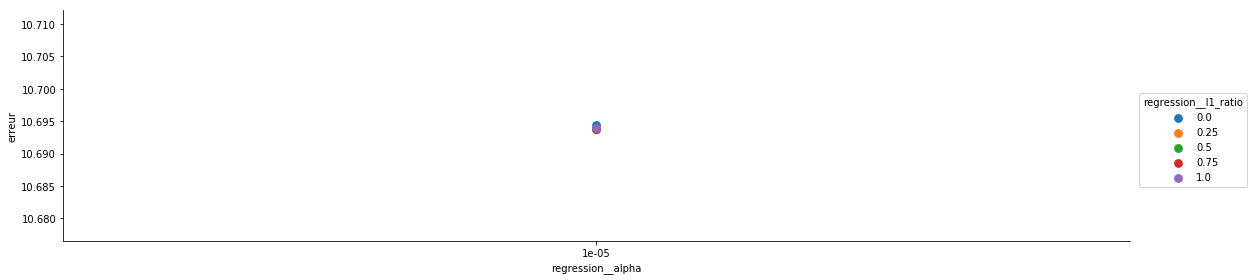

In [22]:
sns.factorplot(x="regression__alpha", y="erreur", hue="regression__l1_ratio", data=results, size=4, aspect=4);

Nous pouvons observer que moins la pénalité est importante, plus l'erreur renvoyée par la fonction de coût diminue, et ce quelque soit le type de pénalité considérée.


Pour conclure, affichons le meilleur score ainsi que le couple d'hyperparamètres qui a permis de l'obtenir

In [23]:
-lr_gridsearch.best_score_

10.693735010555468

In [24]:
lr_gridsearch.best_params_

{'regression__alpha': 1e-05, 'regression__l1_ratio': 0.25}

Enfin, sauvegarder les objets utiles pour l'API: l'encoder des descripteurs catégoriels et le meilleur modèle entrainé 

In [25]:
final_model = lr_gridsearch.best_estimator_

with open('model_infos.pkl', 'wb') as f:
    pickle.dump([nominal_encoder, categorical_encoder, final_model], f)